In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Add, Activation, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load datasets
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'

In [4]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  print(df)
  return df

In [5]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    print(df)
    return df

In [6]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

print(bitcoin_df)
print(nasdaq_df)
print(usd_df)

           Date    Price       Open       High        Low    Vol. Change %
4110 2013-03-01     34.5       33.4       34.9       32.9  39.79K    3.36%
4109 2013-03-02     34.3       34.5       34.8       33.2  36.66K   -0.72%
4108 2013-03-03     34.5       34.3       34.5       33.8  12.53K    0.73%
4107 2013-03-04     36.2       34.5       36.7       34.2  46.77K    4.78%
4106 2013-03-05     40.3       36.2       40.7       36.2  85.43K   11.56%
...         ...      ...        ...        ...        ...     ...      ...
4    2024-05-28  68366.0  69,428.30  69,560.70  67,299.90  71.39K   -1.53%
3    2024-05-29  67635.8  68,366.20  68,897.60  67,143.20  52.13K   -1.07%
2    2024-05-30  68354.7  67,631.30  69,504.70  67,138.40  66.84K    1.06%
1    2024-05-31  67530.1  68,352.30  69,018.20  66,676.80  61.51K   -1.21%
0    2024-06-01  67760.8  67,533.90  67,861.00  67,449.60  19.01K    0.34%

[4111 rows x 7 columns]
           Date     Price       Open       High        Low     Vol. Change 

# DATASET BITCOIN

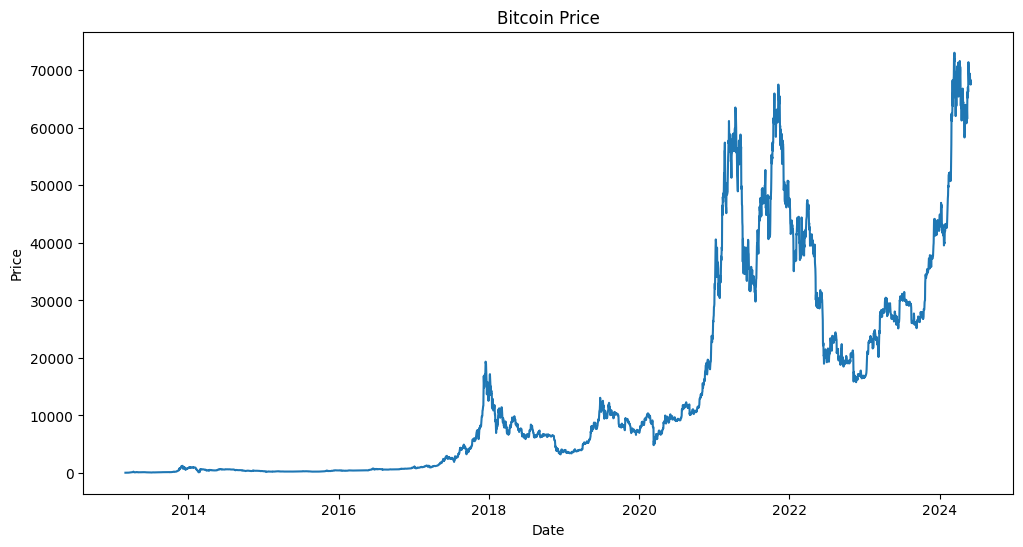

In [7]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


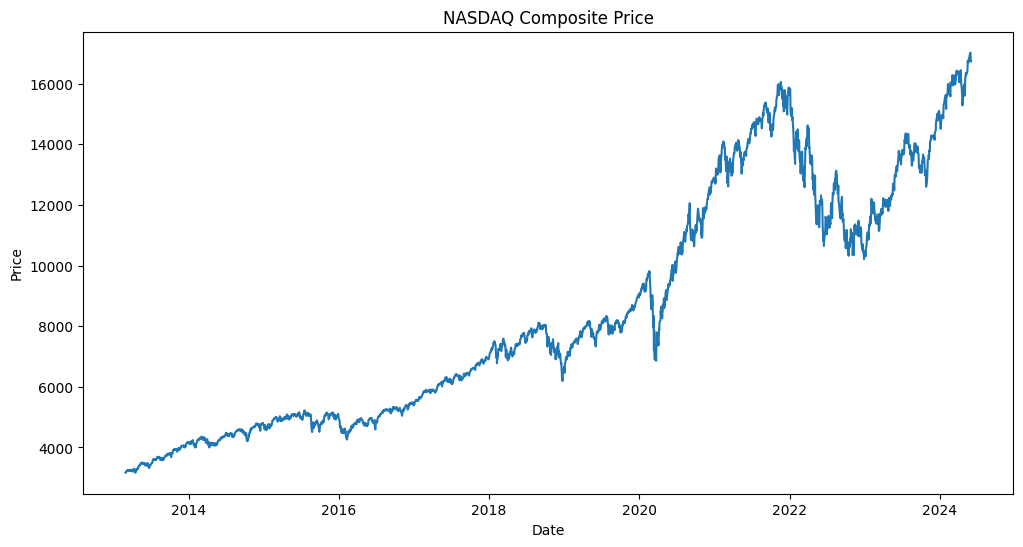

In [8]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

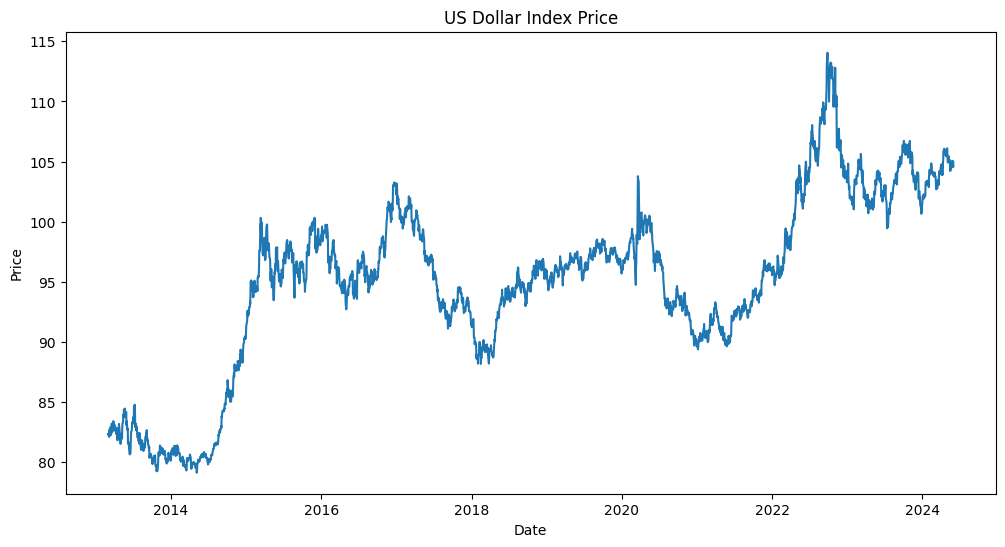

In [9]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [10]:
# Define a function to create sequences and perform forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length][0]  # Predicting 'Price'
        xs.append(x)
        ys.append(y)
        print(np.array(xs), np.array(ys))
    return np.array(xs), np.array(ys)

In [11]:
def rolling_forecast_future(model, data, steps, scaler, window_size=30):
    forecast = []
    last_sequence = data[-window_size:]

    for _ in range(steps // window_size):
        predictions = []

        for _ in range(window_size):
            prediction = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
            predictions.append(prediction[0][0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1, 0] = prediction[0][0]
            print(last_sequence)

        forecast.extend(predictions)

    forecast = np.array(forecast)
    forecast_with_features = np.zeros((forecast.shape[0], data.shape[1]))
    forecast_with_features[:, 0] = forecast  # Fill in the 'Price' predictions
    forecast_with_features = scaler.inverse_transform(forecast_with_features)
    forecast_prices = forecast_with_features[:, 0]  # Extract the 'Price' column
    print(forecast_prices)

    return forecast_prices

In [12]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

In [13]:
def build_res_cnn_block(input_layer):
    conv1 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='linear')(conv2)
    skip_connection = Add()([conv1, conv2])
    skip_connection = Activation('relu')(skip_connection)
    return skip_connection

In [14]:
def build_rescnn_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    res_cnn_block1 = build_res_cnn_block(input_layer)
    res_cnn_block2 = build_res_cnn_block(res_cnn_block1)
    lstm_layer = LSTM(64, return_sequences=False)(res_cnn_block2)
    dense1 = Dense(32, activation='relu')(lstm_layer)
    output_layer = Dense(1, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [15]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    predicted_prices = model.predict(X_test).flatten()
    print(predicted_prices)
    mae = mean_absolute_error(y_test, predicted_prices)
    print(mae)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
    print(rmse)
    mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
    print(mape)
    return predicted_prices, mae, rmse, mape

In [16]:
def process_dataset(df, dataset_name, split_ratio):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']])

    # Create sequences
    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    # Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rescnn_lstm_model(input_shape)
    predicted_prices, mae, rmse, mape = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100)

    # Inverse transform to get actual prices
    y_test_reshaped = y_test.reshape(-1, 1)
    predicted_prices_reshaped = predicted_prices.reshape(-1, 1)
    actual_prices = scaler.inverse_transform(np.hstack((y_test_reshaped, np.zeros((y_test_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]
    predicted_prices_actual = scaler.inverse_transform(np.hstack((predicted_prices_reshaped, np.zeros((predicted_prices_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    # Rolling forecast future prices
    forecast_30 = rolling_forecast_future(model, scaled_data, 30, scaler)
    forecast_60 = rolling_forecast_future(model, scaled_data, 60, scaler)
    forecast_90 = rolling_forecast_future(model, scaled_data, 90, scaler)

    forecast_dates_30 = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')
    forecast_dates_60 = pd.date_range(start=df['Date'].iloc[-1], periods=60, freq='D')
    forecast_dates_90 = pd.date_range(start=df['Date'].iloc[-1], periods=90, freq='D')

    plt.plot(forecast_dates_30, forecast_30, color='brown', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_60[30:], forecast_60[30:], color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_90[60:], forecast_90[60:], color='red', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'ResCNN {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4


Streaming output truncated to the last 5000 lines.
 0.00783081 0.00774866 0.00761995 0.00770484 0.00779521 0.00762542
 0.00759256 0.0073146  0.00750904 0.00777604 0.00771306 0.00776098
 0.00822653 0.00833744 0.00837167 0.00826624 0.00807454 0.00806085
 0.00811151 0.00793214 0.00795542 0.00806085 0.00799786 0.00819641
 0.00823748 0.00812931 0.00799649 0.0080143  0.00794857 0.00811014
 0.00812247 0.00811562 0.00803346 0.0080896  0.008054   0.00804305
 0.00777194 0.00775277 0.00769115 0.00767746 0.00758024 0.00755148
 0.0072612  0.00760215 0.00772949 0.00763227 0.00759393 0.00764733
 0.00759256 0.00760625 0.00764733 0.00768841 0.00760215 0.00763775
 0.00741593 0.00730365 0.00695312 0.00644238 0.00632873 0.00667789
 0.00617811 0.00585908 0.00617264 0.00660669 0.00662175 0.00659711
 0.00634516 0.00650948 0.00641637 0.00654918 0.00658478 0.00652454
 0.00654918 0.00645881 0.00612745 0.00606446 0.00608774 0.0061028
 0.00625342 0.0061521  0.00616442 0.00618222 0.00604393 0.00603297
 0.0060987  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.5267663 ]
 [0.43089166]
 [0.34831765]
 [0.29961073]
 [0.31063554]
 [0.30711451]
 [0.31598803]
 [0.31578344]
 [0.29089355]
 [0.26780614]
 [0.24051824]
 [0.22233132]
 [0.19975689]
 [0.18538882]
 [0.16507979]
 [0.15310207]
 [0.1385631 ]
 [0.12992892]
 [0.11515552]
 [0.10566156]
 [0.09576625]]
1/1 [==============================] - 0s 30ms/step
[[0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.5267663 ]
 [0.43089166]
 [0.34831765]
 [0.29961073]
 [0.31063554]
 [0.30711451]
 [0.31598803]
 [0.31578344]
 [0.29089355]
 [0.26780614]
 [0.24051824]
 [0.22233132]
 [0.19975689]
 [0.18538882]
 [0.16507979]
 [0.15310207]
 [0.1385631 ]
 [0.12992892]
 [0.11515552]
 [0.10566156]
 [0.09576625]
 [0.08938924]]
1/1 [==============================] - 0s 48ms/step
[[0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0

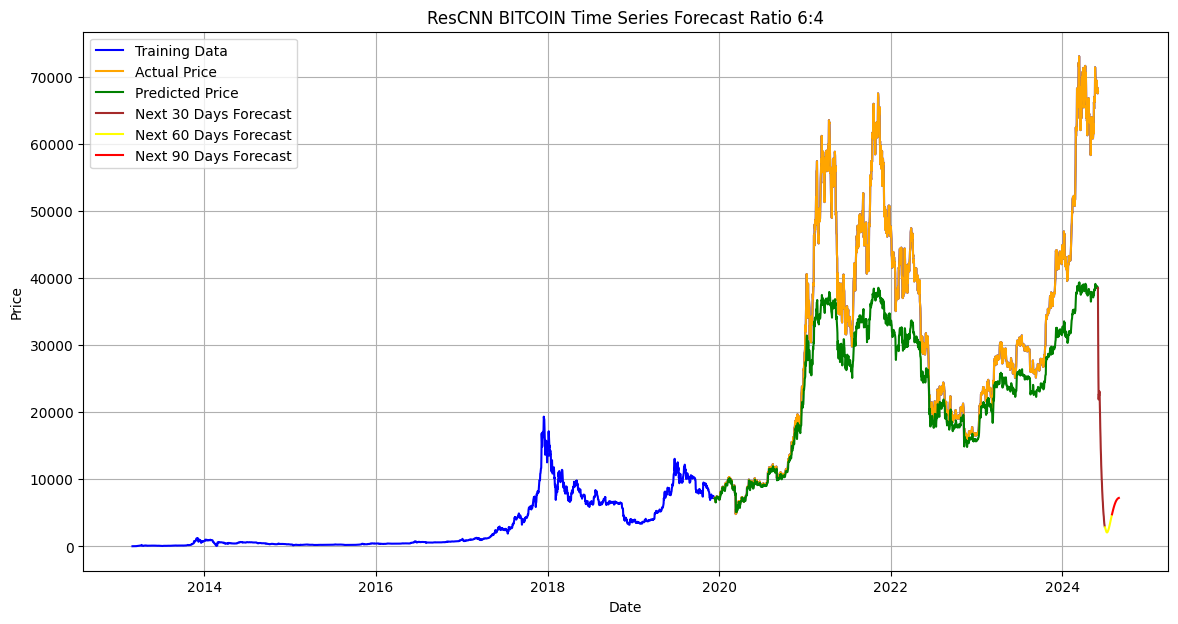

Testing MAE: 0.1022
Testing RMSE: 0.1515
Testing MAPE: 17.11%


In [17]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[3.21639829e-03]
  [3.13561179e-03]
  [2.76454157e-03]
  ...
  [2.75769526e-03]
  [2.80014240e-03]
  [2.80151167e-03]]

 [[3.13561179e-03]
  [2.76454157e-03]
  [2.73441779e-03]
  ...
  [2.80014240e-03]
  [2.80151167e-03]
  [2.77960346e-03]]

 [[2.76454157e-03]
  [2.73441779e-03]
  [2.70429401e-03]
  ...
  [2.80151167e-03]
  [2.77960346e-03]
  [2.76864936e-03]]] [0.00080376 0.00095438 0.00114607 0.00137885 0.00133914 0.0014788
 0.00148291 0.00175266 0.00209771 0.00267965 0.00178963 0.00124055
 0.00113238 0.00080376 0.00076268 0.00065862 0.00046692 0.00080513
 0.00102284 0.00115292 0.00126383 0.0011625  0.00127478 0.00149523
 0.00164175 0.00147059 0.00140486 0.001283   0.00137063 0.00150208
 0.00143636 0.00112416 0.00098587 0.00087359 0.00107624 0.00111869
 0.00106802 0.00103105 0.00108035 0.00107487 0.00114197 0.00111321
 0.00110226 0.00114607 0.0010557  0.00109404 0.001

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.74759072]
 [0.64528072]
 [0.54333395]
 [0.49921677]
 [0.47197205]
 [0.44468507]
 [0.42822117]
 [0.40842736]
 [0.36131558]
 [0.32651502]
 [0.27553192]
 [0.23553012]
 [0.18893895]
 [0.15754253]
 [0.12104243]
 [0.09423366]
 [0.06778836]
 [0.05095647]
 [0.03562101]
 [0.02153771]
 [0.01343108]]
1/1 [==============================] - 0s 33ms/step
[[0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.74759072]
 [0.64528072]
 [0.54333395]
 [0.49921677]
 [0.47197205]
 [0.44468507]
 [0.42822117]
 [0.40842736]
 [0.36131558]
 [0.32651502]
 [0.27553192]
 [0.23553012]
 [0.18893895]
 [0.15754253]
 [0.12104243]
 [0.09423366]
 [0.06778836]
 [0.05095647]
 [0.03562101]
 [0.02153771]
 [0.01343108]
 [0.00855141]]
1/1 [==============================] - 0s 31ms/step
[[0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0

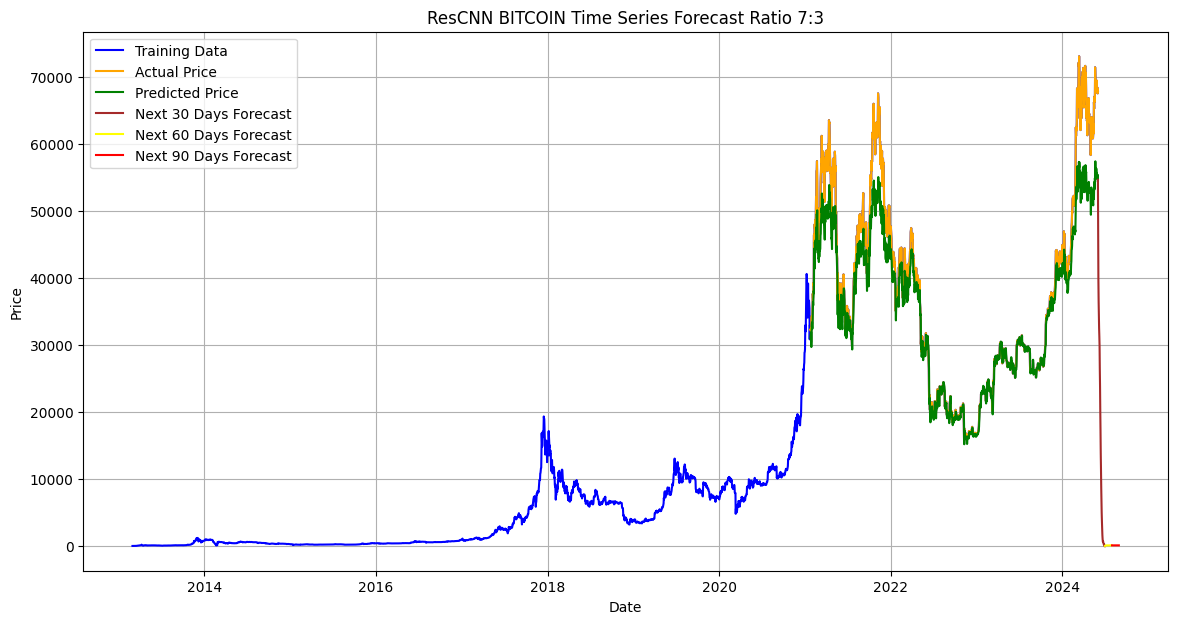

Testing MAE: 0.0402
Testing RMSE: 0.0653
Testing MAPE: 5.88%


In [18]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.92687249]
 [0.92735094]
 [0.92771602]
 [0.92832196]
 [0.92894918]
 [0.92930287]
 [0.92967451]
 [0.92974848]
 [0.92992014]
 [0.92988384]
 [0.92987412]
 [0.92977792]
 [0.92976898]
 [0.92966717]
 [0.92960668]
 [0.92953473]
 [0.92950904]
 [0.92945766]
 [0.92941695]
 [0.92936605]
 [0.92934471]]
1/1 [==============================] - 0s 21ms/step
[[0.94821585]
 [0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0.92735376]
 [0.92687249]
 [0.92735094]
 [0.92771602]
 [0.92832196]
 [0.92894918]
 [0.92930287]
 [0.92967451]
 [0.92974848]
 [0.92992014]
 [0.92988384]
 [0.92987412]
 [0.92977792]
 [0.92976898]
 [0.92966717]
 [0.92960668]
 [0.92953473]
 [0.92950904]
 [0.92945766]
 [0.92941695]
 [0.92936605]
 [0.92934471]
 [0.92931283]]
1/1 [==============================] - 0s 21ms/step
[[0.937678  ]
 [0.9501917 ]
 [0.93564054]
 [0.92564218]
 [0.93548581]
 [0.92419487]
 [0

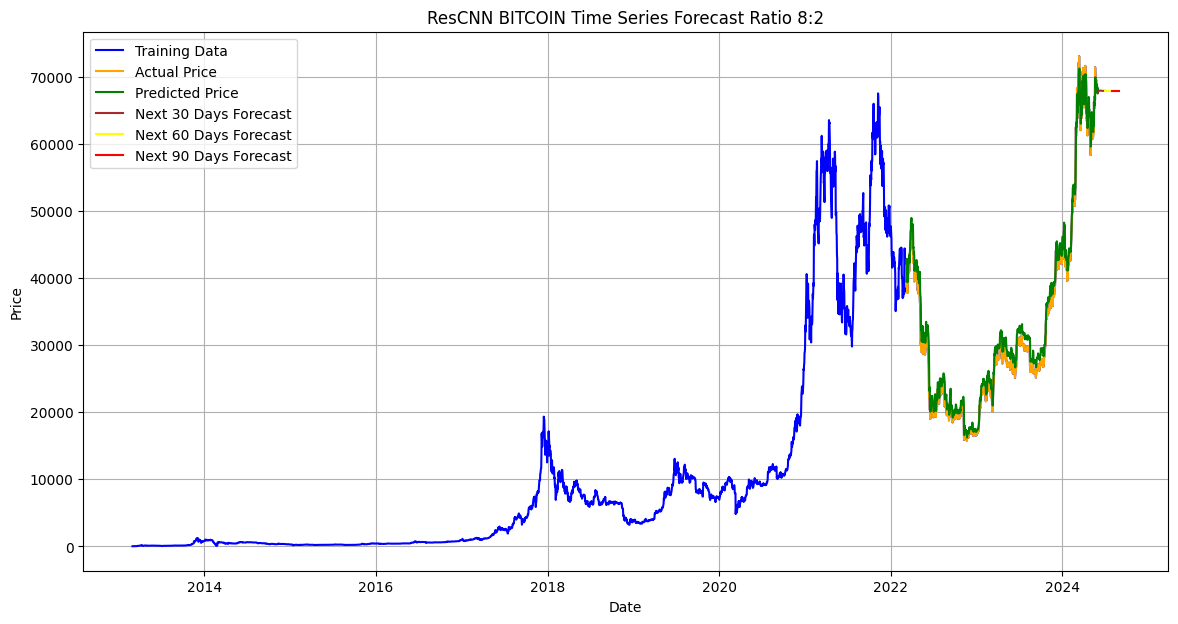

Testing MAE: 0.0187
Testing RMSE: 0.0221
Testing MAPE: 4.60%


In [19]:
results = process_dataset(bitcoin_df, "BITCOIN", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.91230637]
 [0.86396152]
 [0.81524056]
 [0.7742604 ]
 [0.74348152]
 [0.71635097]
 [0.69332606]
 [0.67339915]
 [0.65482354]
 [0.63721031]
 [0.62136555]
 [0.60607594]
 [0.58972555]
 [0.57349855]
 [0.55816716]
 [0.5430668 ]
 [0.52715921]
 [0.51180208]
 [0.49701023]
 [0.48275661]
 [0.46809024]]
1/1 [==============================] - 0s 31ms/step
[[0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.91230637]
 [0.86396152]
 [0.81524056]
 [0.7742604 ]
 [0.74348152]
 [0.71635097]
 [0.69332606]
 [0.67339915]
 [0.65482354]
 [0.63721031]
 [0.62136555]
 [0.60607594]
 [0.58972555]
 [0.57349855]
 [0.55816716]
 [0.5430668 ]
 [0.52715921]
 [0.51180208]
 [0.49701023]
 [0.48275661]
 [0.46809024]
 [0.45429921]]
1/1 [==============================] - 0s 44ms/step
[[0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0

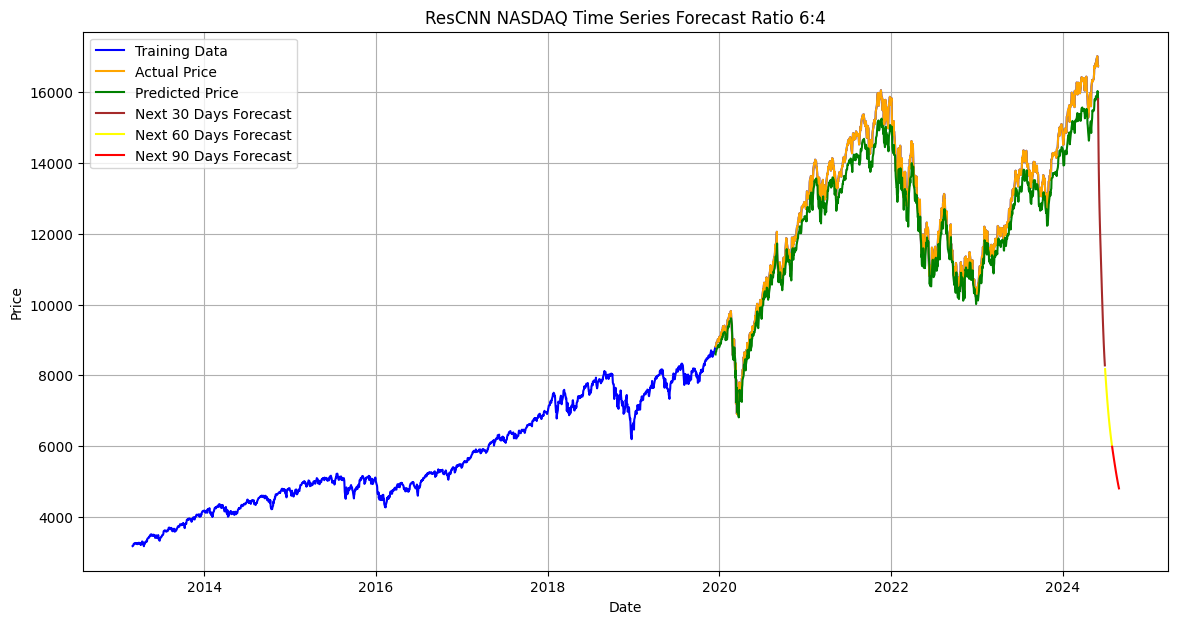

Testing MAE: 0.0326
Testing RMSE: 0.0370
Testing MAPE: 4.57%


In [20]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 0.07109168 0.07141867 0.07453918 0.07952347 0.08013126 0.0773363
 0.06939536 0.06593198 0.06833137 0.07344992 0.06408119 0.06015583
 0.06181317 0.06264112 0.06639901 0.06707032 0.06894926 0.07183012
 0.0693405  0.07088307 0.06562953 0.0655458  0.06764923 0.0684447
 0.06937515 0.0691189  0.07014102 0.06600489 0.06506    0.06389279
 0.06536317 0.07055968 0.06957077 0.06743918 0.06517694 0.06671445
 0.06925677 0.06716921 0.06967038 0.07131617 0.0735878  0.07728794
 0.07642173 0.0780733  0.07768856 0.07729732 0.07707211 0.07833966
 0.08155833 0.0833752  0.08444641 0.08457345 0.0841353  0.08165939
 0.08259922 0.08335354 0.08451787 0.0863665  0.08611313 0.08674185
 0.08678805 0.08546492 0.08758785 0.0875366  0.08889943 0.08963931
 0.09328243 0.09321602 0.0952516  0.09276848 0.0884324  0.09042251
 0.08877455 0.09016698 0.09196652 0.09023194 0.09092346 0.08641053
 0.09136956 0.09083179 0.09309259 0.0943688  0.09425402 0.09262628
 0.09229062 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.94834554]
 [0.92646295]
 [0.90296292]
 [0.8828997 ]
 [0.86789423]
 [0.85422921]
 [0.84284502]
 [0.83310372]
 [0.82412076]
 [0.815943  ]
 [0.808631  ]
 [0.80170071]
 [0.79517621]
 [0.78893656]
 [0.78287661]
 [0.77702302]
 [0.77129215]
 [0.76562643]
 [0.76009822]
 [0.75471699]
 [0.74942023]]
1/1 [==============================] - 0s 31ms/step
[[0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.94834554]
 [0.92646295]
 [0.90296292]
 [0.8828997 ]
 [0.86789423]
 [0.85422921]
 [0.84284502]
 [0.83310372]
 [0.82412076]
 [0.815943  ]
 [0.808631  ]
 [0.80170071]
 [0.79517621]
 [0.78893656]
 [0.78287661]
 [0.77702302]
 [0.77129215]
 [0.76562643]
 [0.76009822]
 [0.75471699]
 [0.74942023]
 [0.74419427]]
1/1 [==============================] - 0s 55ms/step
[[0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0

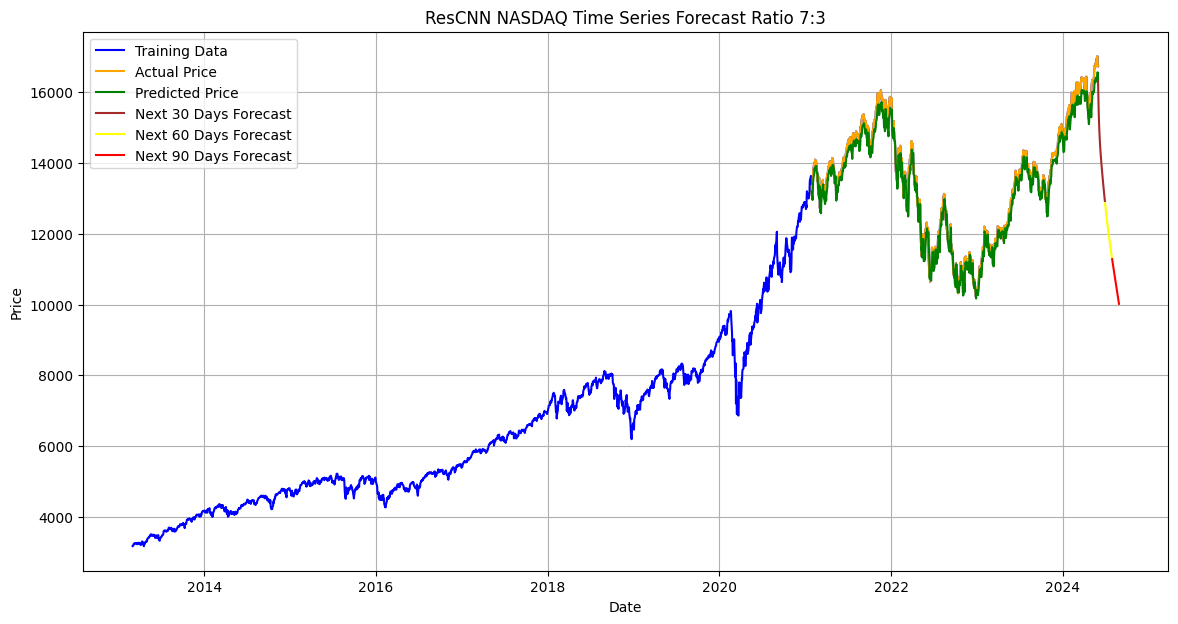

Testing MAE: 0.0159
Testing RMSE: 0.0191
Testing MAPE: 2.10%


In [21]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.

 [[0.00417006]
  [0.00404302]
  [0.00474464]
  ...
  [0.00928212]
  [0.00361857]
  [0.0070935 ]]

 ...

 [[0.13604773]
  [0.13452249]
  [0.13636895]
  ...
  [0.14475816]
  [0.14292757]
  [0.13875679]]

 [[0.13452249]
  [0.13636895]
  [0.13704243]
  ...
  [0.14292757]
  [0.13875679]
  [0.13523061]]

 [[0.13636895]
  [0.13704243]
  [0.14195598]
  ...
  [0.13875679]
  [0.13523061]
  [0.13879866]]] [0.00361857 0.0070935  0.00276536 0.         0.0028657  0.00485003
 0.00743277 0.00745587 0.00892409 0.00814955 0.01015338 0.01172482
 0.00958385 0.01257875 0.01532246 0.01635758 0.01662177 0.01782291
 0.01752695 0.01950551 0.01966504 0.02138446 0.02203483 0.0215743
 0.02400906 0.02382571 0.02423644 0.02143426 0.02115419 0.02113398
 0.02328145 0.02173888 0.02345541 0.02090083 0.02158368 0.02013207
 0.01697186 0.01860105 0.02186159 0.02219003 0.01953222 0.01689607
 0.02013929 0.01856568 0.02062797 0.02279709 0.01998337 0.01431261
 0.01377917 0.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.99709713]
 [1.01177073]
 [1.02700496]
 [1.04099798]
 [1.05395913]
 [1.06539261]
 [1.07582223]
 [1.08512747]
 [1.09350681]
 [1.10064626]
 [1.10724592]
 [1.11302161]
 [1.11831689]
 [1.12296212]
 [1.12720311]
 [1.13084257]
 [1.13413167]
 [1.13709891]
 [1.13972974]
 [1.14201188]
 [1.14401412]]
1/1 [==============================] - 0s 31ms/step
[[0.98648286]
 [0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0.97958642]
 [0.97943772]
 [0.99709713]
 [1.01177073]
 [1.02700496]
 [1.04099798]
 [1.05395913]
 [1.06539261]
 [1.07582223]
 [1.08512747]
 [1.09350681]
 [1.10064626]
 [1.10724592]
 [1.11302161]
 [1.11831689]
 [1.12296212]
 [1.12720311]
 [1.13084257]
 [1.13413167]
 [1.13709891]
 [1.13972974]
 [1.14201188]
 [1.14401412]
 [1.14584792]]
1/1 [==============================] - 0s 50ms/step
[[0.98423938]
 [0.97951062]
 [0.99284731]
 [1.        ]
 [0.99283215]
 [0

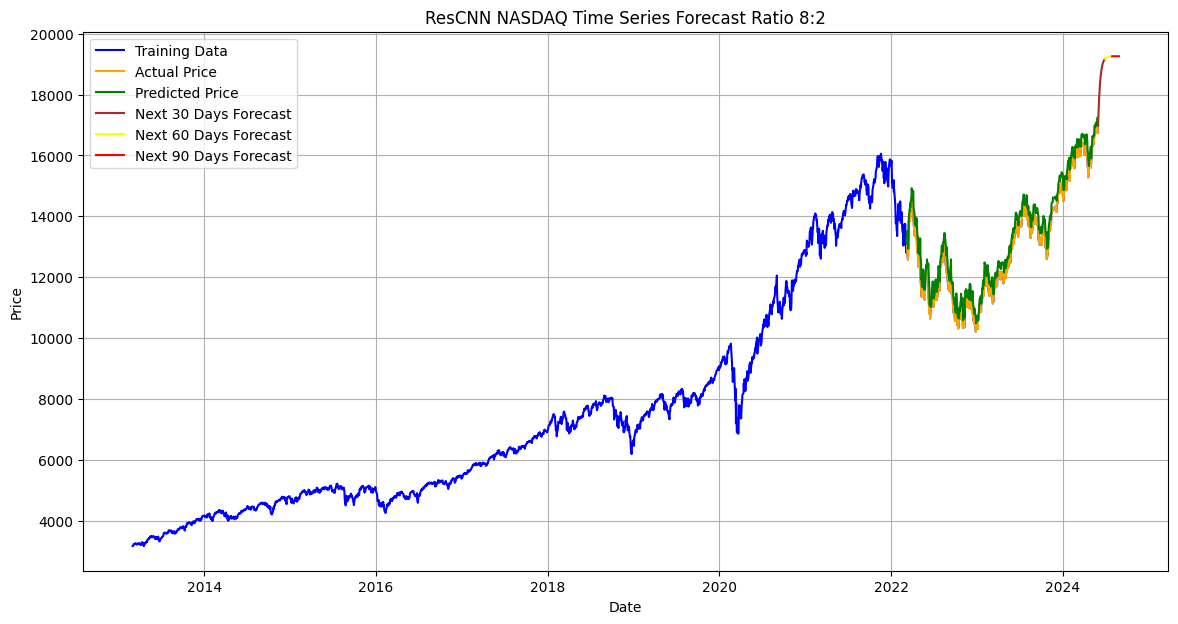

Testing MAE: 0.0229
Testing RMSE: 0.0262
Testing MAPE: 3.32%


In [22]:
results = process_dataset(nasdaq_df, "NASDAQ", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.72358328]
 [0.72338462]
 [0.72306311]
 [0.72291762]]
1/1 [==============================] - 0s 30ms/step
[[0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.72846705]
 [0.72713965]
 [0.72711849]
 [0.72671717]
 [0.72639173]
 [0.72609514]
 [0.72586793]
 [0.72563124]
 [0.72550249]
 [0.72523385]
 [0.724913  ]
 [0.72478276]
 [0.72455633]
 [0.72430122]
 [0.72396833]
 [0.72387069]
 [0.72358328]
 [0.72338462]
 [0.72306311]
 [0.72291762]
 [0.72261572]]
1/1 [==============================] - 0s 21ms/step
[[0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.72846705]
 [0.72713965]
 [0.72711849]
 [0.72671717]
 [0.72639173]
 [0.72609514]
 [0.72586793]
 [0.72563124]
 [0.72550249]
 [0.72523385]
 [0.724913  ]
 [0.72478276]
 [0.72455633]
 [0.72430122]
 [0.72396833]
 [0.72387069]
 [0.72358328]
 [0.72338462]
 [0

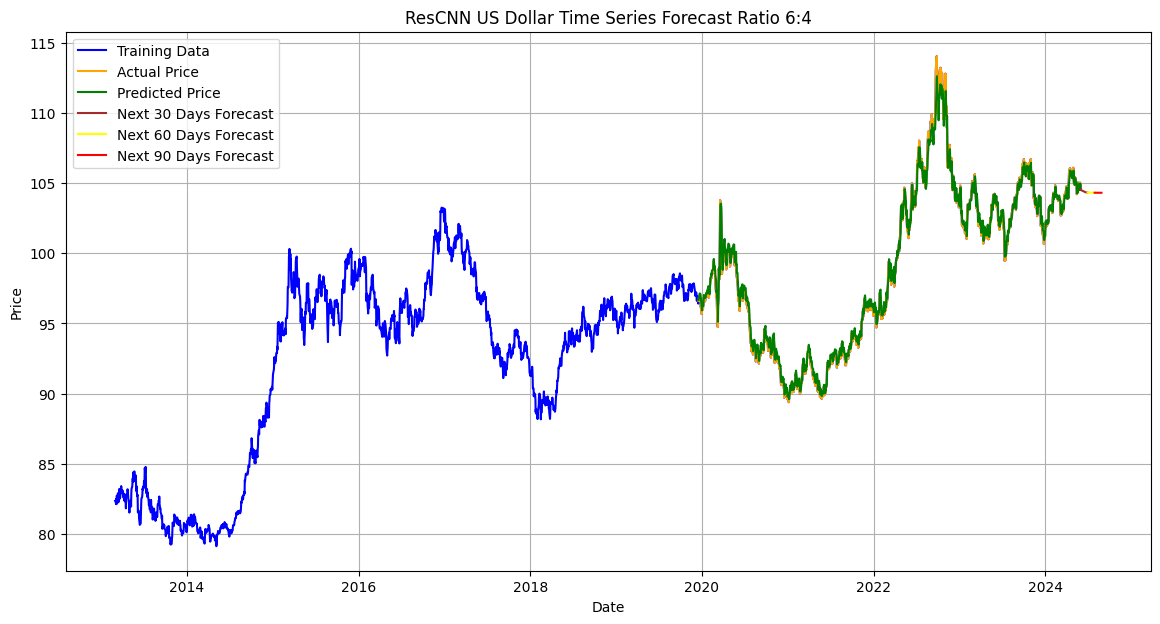

Testing MAE: 0.0108
Testing RMSE: 0.0147
Testing MAPE: 1.93%


In [23]:
results = process_dataset(usd_df, "US Dollar", 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 0.06007846 0.05735804 0.05372126 0.04673406 0.04584634 0.04518771
 0.04624724 0.03585235 0.03015378 0.03015378 0.02634518 0.03035423
 0.03407692 0.03275966 0.03147103 0.02975287 0.03828642 0.03379056
 0.01700982 0.02760517 0.03026832 0.02837834 0.01543484 0.01706709
 0.01841299 0.01743936 0.01391713 0.01431803 0.00893445 0.00529767
 0.01196987 0.02883652 0.03513645 0.03250193 0.02729017 0.02754789
 0.02986742 0.03224421 0.034621   0.03230148 0.0321583  0.03568054
 0.043355   0.04137911 0.03519372 0.02030297 0.0122276  0.00927808
 0.01136852 0.01944389 0.02182068 0.0216775  0.02225022 0.025887
 0.02488474 0.02316658 0.02150568 0.01981616 0.01821254 0.02162023
 0.01162624 0.01297214 0.01251396 0.01156897 0.         0.00335042
 0.00790355 0.02391111 0.02402566 0.0311274  0.02889379 0.02686063
 0.02809198 0.02640245 0.02769107 0.02932333 0.03376192 0.03791415
 0.03791415 0.03662553 0.04278228 0.04049139 0.03659689 0.0447868
 0.04200911 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.64957505]
 [0.64705491]
 [0.64437294]
 [0.64186388]]
1/1 [==============================] - 0s 31ms/step
[[0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.72103435]
 [0.71223754]
 [0.70406336]
 [0.69662476]
 [0.6902982 ]
 [0.68488693]
 [0.68022674]
 [0.67609936]
 [0.67233777]
 [0.66889679]
 [0.66571075]
 [0.66291606]
 [0.66009706]
 [0.65741664]
 [0.65466624]
 [0.6521858 ]
 [0.64957505]
 [0.64705491]
 [0.64437294]
 [0.64186388]
 [0.63934714]]
1/1 [==============================] - 0s 39ms/step
[[0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.72103435]
 [0.71223754]
 [0.70406336]
 [0.69662476]
 [0.6902982 ]
 [0.68488693]
 [0.68022674]
 [0.67609936]
 [0.67233777]
 [0.66889679]
 [0.66571075]
 [0.66291606]
 [0.66009706]
 [0.65741664]
 [0.65466624]
 [0.6521858 ]
 [0.64957505]
 [0.64705491]
 [0

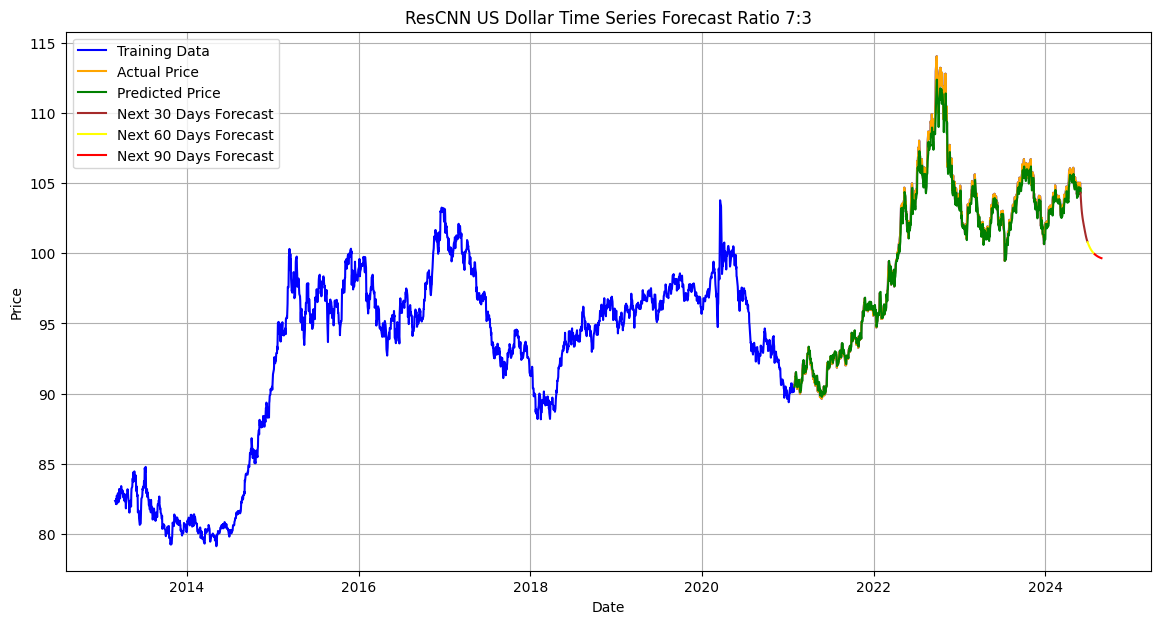

Testing MAE: 0.0120
Testing RMSE: 0.0166
Testing MAPE: 1.89%


In [24]:
results = process_dataset(usd_df, "US Dollar", 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 0.49044987 0.48002635 0.47971135 0.50428109 0.47521549 0.47037599
 0.4554566  0.4641906  0.46135563 0.45748976 0.47332551 0.4508462
 0.44342946 0.44440308 0.45098938 0.48357722 0.47707683 0.47524412
 0.48288995 0.46338879 0.48351995 0.50780333 0.50224793 0.50224793
 0.50703015 0.52446952 0.50731651 0.51622233 0.49815297 0.52152
 0.51533461 0.52950946 0.54460067 0.54989834 0.55410784 0.53306034
 0.54162252 0.52727585 0.53085536 0.51006558 0.51716732 0.52335271
 0.54044844 0.53363306 0.53878755 0.55032788 0.55072879 0.54703474
 0.53901664 0.52664586 0.53082672 0.50067295 0.50536926 0.50763151
 0.51570688 0.52295181 0.50287792 0.49251167 0.46401879 0.41665473
 0.45081756 0.46734057 0.48234587 0.49488846 0.48707082 0.47544457
 0.48684173 0.50342201 0.49823888 0.49823888 0.48987715 0.4893617
 0.47266688 0.46542195 0.46636694 0.48334813 0.47636093 0.45061711
 0.45955156 0.48904671 0.50121703 0.49448756 0.4928553  0.50101658
 0.49414392 0.48

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.62732667]
 [0.62426859]
 [0.62111127]
 [0.61813647]]
1/1 [==============================] - 0s 75ms/step
[[0.72821511]
 [0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.71700847]
 [0.70536387]
 [0.69486487]
 [0.68525648]
 [0.67701089]
 [0.67011076]
 [0.66428202]
 [0.65925092]
 [0.65485668]
 [0.65073442]
 [0.64697307]
 [0.64357513]
 [0.64018518]
 [0.63687414]
 [0.633569  ]
 [0.630485  ]
 [0.62732667]
 [0.62426859]
 [0.62111127]
 [0.61813647]
 [0.61515111]]
1/1 [==============================] - 0s 44ms/step
[[0.73623321]
 [0.74196042]
 [0.73056327]
 [0.73056327]
 [0.7277283 ]
 [0.74190315]
 [0.73113599]
 [0.73024827]
 [0.71700847]
 [0.70536387]
 [0.69486487]
 [0.68525648]
 [0.67701089]
 [0.67011076]
 [0.66428202]
 [0.65925092]
 [0.65485668]
 [0.65073442]
 [0.64697307]
 [0.64357513]
 [0.64018518]
 [0.63687414]
 [0.633569  ]
 [0.630485  ]
 [0.62732667]
 [0.62426859]
 [0

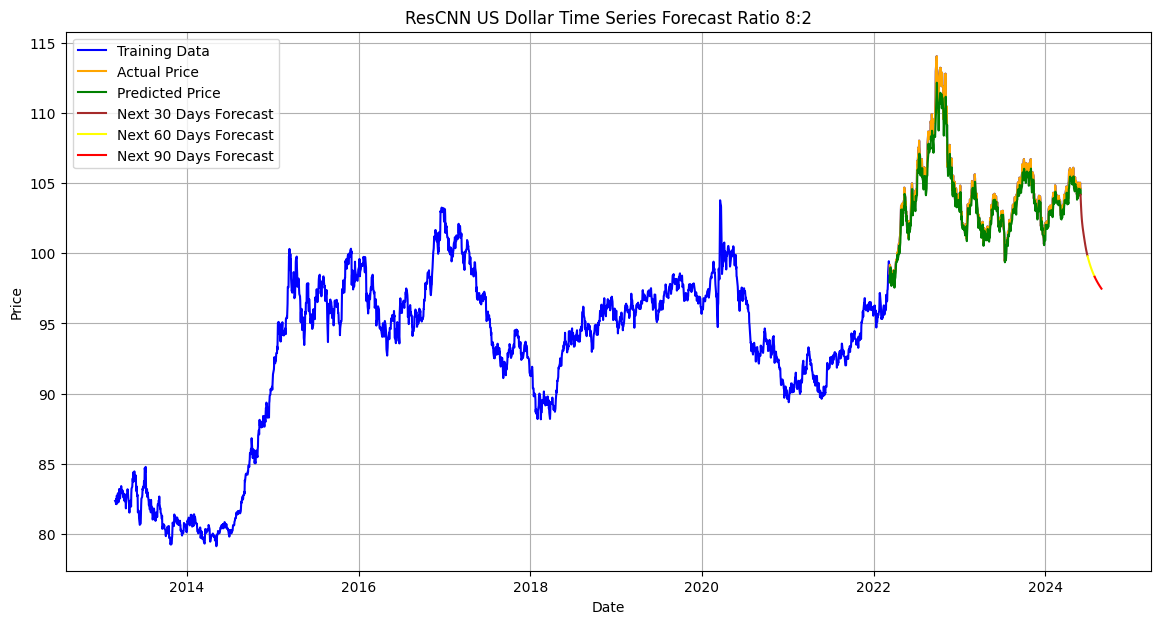

Testing MAE: 0.0166
Testing RMSE: 0.0218
Testing MAPE: 2.22%


In [25]:
results = process_dataset(usd_df, "US Dollar", 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')